In [62]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm
import pickle
from umap import UMAP

ModuleNotFoundError: No module named 'glmnet'

In [22]:
def load_and_reformat(path_emb, path_counts):
    """Load emb and counts df and reformatting to make them suitable for merge"""
    # Load and reformat embeddings from pickle file
    emb_input = pd.read_pickle(path_emb)
        
    reformatted_emb = {}
    for k, v in emb_input.items():
        new_k = k.replace('-', '_')
        v = v
        reformatted_emb[new_k] = v
    
    # Load and reformat ORF2 counts
    ORF2_counts = pd.read_csv(path_counts)
    
    reformatted_counts_dict = {}
    counts = ORF2_counts['Non_redundant']
    names = ORF2_counts['ID']
    for i in range(len(ORF2_counts)):
        number = counts[i]
        ID = names[i]
        not_dash = ID.replace('-', '_')
        clean = not_dash.replace('.', '_')
        reformatted_counts_dict[clean] = number
    a = pd.DataFrame.from_dict(reformatted_counts_dict, orient='index')
    reformatted_counts = a.reset_index()
    reformatted_counts.columns = ['ID','Non_redundant']
    
    # Combine embeddings and ORF2 counts
    matrix_inverted = pd.DataFrame(reformatted_emb)
    matrix = matrix_inverted.transpose()
    
    return reformatted_emb, reformatted_counts, matrix

def match_ID(matrix, reformatted_counts):
    """Matching matrix (embs) and IDs from counts file to use embs observations with counts associated (all)"""
    
   #matched_IDs = matrix.loc[:, matrix.index.isin(reformatted_counts["ID"].values)]
    matched_emb = matrix.loc[matrix.index.isin(reformatted_counts['ID'].values)]
    matched_counts = reformatted_counts.loc[reformatted_counts['ID'].isin(matrix.index)]
    counts_array = np.array(matched_counts['Non_redundant'])
    
    return matched_emb, matched_counts

**Reading files and merging**

In [13]:
# -- Read pickle file containing embeddings and reformat to remove dash that block merge
path_emb = '/Users/leandrojorqueravalero/Desktop/PhD/synthetic_ORF2/data/embeddings_v2.pickle'
path_counts = '/Users/leandrojorqueravalero/Desktop/PhD/synthetic_ORF2/data/ORF2p_counts.csv'

reformatted_emb = load_and_reformat(path_emb, path_counts)[0]
reformatted_counts = load_and_reformat(path_emb, path_counts)[1]
matrix = load_and_reformat(path_emb, path_counts)[2]

In [14]:
# -- Matching datasets
matched_emb = match_ID(matrix, reformatted_counts)[0]
#matches_emb
matched_counts = match_ID(matrix, reformatted_counts)[1]
#matched_counts

,ID,Non_redundant
0,L1M5_orf2DF0000008,114873
2,L1M1_orf2DF0000228,11129
3,L1M2_orf2DF0000236,17500
4,L1M3_orf2DF0000244,21747
6,L1M4_orf2DF0000250,32089
...,...,...
1341,TE3105_SO2_FAM184DF0289547,2731
1342,TE3121_SO2_FAM192DF0289563,1546
1343,TE3146_SO2_FAM209DF0289588,2789
1351,TE3261_SO2_FAM454DF0289702,796


In [15]:
print(len(matrix.index), len(matched_emb.index), len(matched_counts.index))  # Test number of matchs between datasets

721 720 720


# Using sklearn PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [ ]:
def extract_dimension(matched_emb):
    """Extract PC weights with sklearn (from embeddings file) and return component with highest weight"""
    
    pca = PCA()  # Define PCA function
    my_pca = pca.fit_transform(matched_emb)   # Scale data and apply PCA on embeddings df
    dataframe_pca = pd.DataFrame(my_pca)  # Convert to df
    
    df_pca_loadings = pd.DataFrame(pca.components_) # Show Principal Components Weights (Eigenvectors) for every dimension
    a = df_pca_loadings.describe()    # Print mean of every dimension weight (column) for all sequences 
    best_dimension = a.iloc[1].idxmax(axis=1)  # Extract highest mean value among all dimensions
    dimension_array = np.array(df_pca_loadings[best_dimension+1])  # Retrieve dimension value for every sequence (column indexing starts with 0)
    
    return dimension_array


In [19]:
dimension_array = extract_dimension(matched_emb)
X = dimension_array.reshape(-1,1)
X.shape

array([-0.00168625, -0.02031933,  0.04143126,  0.06644992,  0.05290947,
       -0.05912785, -0.00905503, -0.04693041, -0.00733922,  0.0036309 ,
        0.0480717 ,  0.05098446, -0.00125069,  0.03401736,  0.01718287,
        0.04483273,  0.01617949,  0.01798893,  0.03922728, -0.00206607,
       -0.00761671,  0.03176487, -0.00946022, -0.04054015,  0.01053592,
       -0.01932068,  0.01445481,  0.04183023, -0.01828918,  0.06625762,
        0.01610267, -0.0011192 , -0.00807835, -0.02793122,  0.03794137,
        0.02261639, -0.01254015,  0.00981117, -0.02304997,  0.03967946,
       -0.01535823, -0.01891427, -0.00232152,  0.03537039, -0.04506485,
        0.02045383,  0.02156671,  0.03381547,  0.02022549, -0.00219986,
        0.0308005 ,  0.00018438, -0.0028065 ,  0.02894531,  0.00788009,
       -0.04607819,  0.04224192,  0.00455411, -0.01444363, -0.00082537,
        0.00689791, -0.01688863, -0.02916647,  0.01410681,  0.02327239,
       -0.00036337,  0.02195083, -0.00684829,  0.0006586 ,  0.02

In [30]:
counts_array = match_ID(matrix, reformatted_counts)[1]
y = counts_array.reshape(-1,1)   #-1 as segundo argument in reshape infer the number of features
y.shape

array([[ 114873],
       [  11129],
       [  17500],
       [  21747],
       [  32089],
       [  18798],
       [  24264],
       [  17972],
       [  14925],
       [   9575],
       [  11628],
       [ 176045],
       [   4347],
       [    824],
       [     72],
       [     59],
       [     43],
       [    108],
       [    427],
       [    251],
       [    291],
       [    114],
       [    505],
       [     48],
       [    238],
       [    296],
       [    134],
       [  16689],
       [   4583],
       [   4421],
       [   4855],
       [   2413],
       [   3904],
       [   8403],
       [    242],
       [   4934],
       [   1650],
       [   9960],
       [   2926],
       [   2294],
       [   4829],
       [   2347],
       [   1113],
       [   4924],
       [    642],
       [    818],
       [    948],
       [   7414],
       [   4396],
       [    424],
       [   2211],
       [   1145],
       [   1332],
       [   7001],
       [   3707],
       [  

**Performing linear regression**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)  # split dataset

In [25]:
regr = LinearRegression()   # Define model

In [26]:
regr.fit(X_train, y_train)   # Fit linear model (training data)

LinearRegression()

In [27]:
print(regr.score(X_test, y_test))   # The best possible score is 1.0

-0.0006342600794913


**Exploring results**

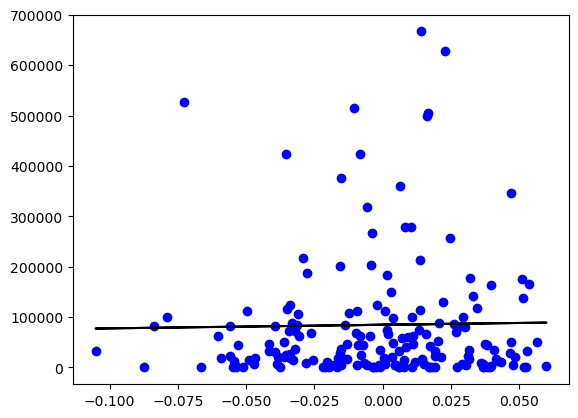

In [29]:
y_pred = regr.predict(X_test)     # Predict counts for X_test subset
plt.scatter(X_test, y_test, color = 'b')
plt.plot(X_test,y_pred, color='k')
plt.show()

# Using Scanpy

In [66]:
import scanpy as sc
import anndata as ad
from statsmodels.formula.api import sm
from glmnet import glmnet
from glmnetPlot import glmnetPlot

ImportError: cannot import name 'sm' from 'statsmodels.formula.api' (/Users/leandrojorqueravalero/miniconda3/envs/bioinfo/lib/python3.8/site-packages/statsmodels/formula/api.py)

In [57]:
def AnnData_Object(matched_emb):
    """ anndata is a Python package for handling annotated data matrices in memory and on disk, 
        positioned between pandas and xarray"""
    #adata = ad.AnnData(X=matched_IDs.index, obs=pd.DataFrame(index=matched_IDs.columns))
    adata = ad.AnnData(X = matched_emb.values, obs = matched_emb.index.to_list(),var = matched_emb.columns.tolist())
    
    return adata

def add_counts(adata, matched_counts):
    """Including counts information in emb matrix"""
    ID_embeddings = pd.DataFrame(matched_emb.index)
    ID_embeddings.columns = ["ID"]
    ID_embeddings_with_counts = pd.merge(ID_embeddings, matched_counts)
    ID_embeddings_with_counts.columns = ['ID', 'Non_redundant']
    #assert all(ID_embeddings.index == ID_embeddings_with_counts["ID"])
    #adata.obs["ORF_all_counts"] = ID_embeddings_with_counts["All"].values
    adata.obs["Non_redundant"] = pd.Categorical(ID_embeddings_with_counts["Non_redundant"].values)


**PCA + extracting information**

In [25]:
adata = AnnData_Object(matched_emb)
#adata.obs
adata.var_keys

<bound method AnnData.var_keys of AnnData object with n_obs × n_vars = 720 × 1024
    obs: 0
    var: 0>

In [60]:
add_counts(adata, matched_counts)

In [26]:
sc.pp.scale(adata)
sc.tl.pca(adata)

In [29]:
adata.uns_keys

<bound method AnnData.uns_keys of AnnData object with n_obs × n_vars = 720 × 1024
    obs: 0
    var: 0, 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'>

In [27]:
# Retrieve PCA representation of data
mat = adata.obsm['X_pca']

In [37]:
# Ratio of variance explained by each PC
var_ratio = adata.uns['pca']['variance_ratio']

In [46]:
# Explained variance (%), equivalent to the eigenvalues of the covariance matrix
var_explained = (adata.uns['pca']['variance'])/10
var_explained

array([46.970543  , 11.31      ,  9.463572  ,  5.4767017 ,  4.0619283 ,
        3.9542928 ,  2.786041  ,  2.1401389 ,  1.7903    ,  1.6017752 ,
        1.209511  ,  1.0893626 ,  0.81831634,  0.7406155 ,  0.6203817 ,
        0.6078838 ,  0.54545295,  0.48152184,  0.43925053,  0.38774788,
        0.3441468 ,  0.26880068,  0.25482008,  0.24160191,  0.20716088,
        0.18986784,  0.1835089 ,  0.17355648,  0.1687501 ,  0.14301442,
        0.1356752 ,  0.12592152,  0.11923894,  0.1129609 ,  0.10450009,
        0.09746362,  0.09329531,  0.09112995,  0.08632775,  0.08090194,
        0.07880943,  0.07536968,  0.07218277,  0.06826825,  0.06800883,
        0.06180674,  0.05960389,  0.05875107,  0.05588206,  0.0528238 ],
      dtype=float32)

In [33]:
# Calculate explained variance
total_variance = sum(np.var(mat, axis = 0))
eigValues = np.square(adata.var['std'])
var_explained = eigValues / total_variance

/var/folders/tb/6wx3385d0_s3jtpq965v4vkw0000gn/T/ipykernel_15829/4039168653.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(np.diff(var_explained) * (-1)))


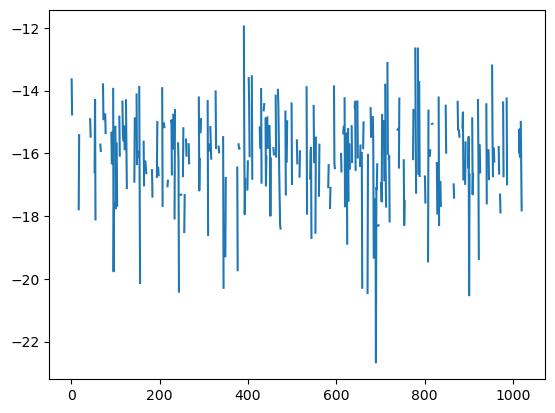

In [34]:
# plot explained variance
plt.plot(np.log(np.diff(var_explained) * (-1)))

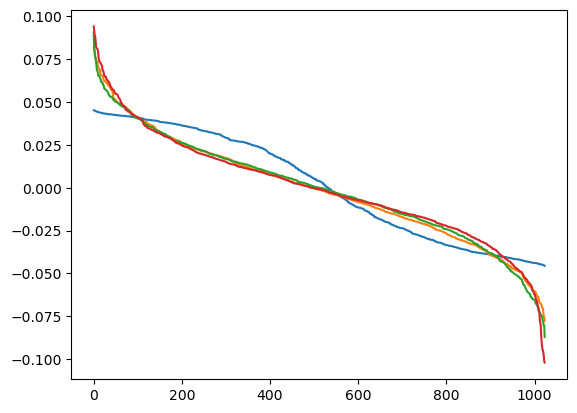

In [53]:
# Extract and plot PCA eigenvectors
eigenvectors = adata.varm['PCs']

plt.plot(sorted(eigenvectors[:,0], reverse=True))
plt.plot(sorted(eigenvectors[:,1], reverse=True))
plt.plot(sorted(eigenvectors[:,2], reverse=True))
plt.plot(sorted(eigenvectors[:,3], reverse=True))

In [56]:
# identify important features using eigenvectors
weights = list(set(adata.var_names[np.where(np.abs(eigenvectors[:,0]) > 0.05)[0]].tolist() + \
                    adata.var_names[np.where(np.abs(eigenvectors[:,1]) > 0.06)[0]].tolist() + \
                   adata.var_names[np.where(np.abs(eigenvectors[:,2]) > 0.07)[0]].tolist() + \
                   adata.var_names[np.where(np.abs(eigenvectors[:,3]) > 0.08)[0]].tolist()))

In [61]:
# Create a new dataframe for modeling
df = pd.DataFrame(adata.obsm['X_pca'], columns=['PC'+str(i+1) for i in range(mat.shape[1])])
df['counts'] = adata.obs['Non_redundant'].tolist()

**Perform standard linear regression**

In [ ]:
X = df.drop('counts', axis=1)
y = df['counts']
model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(model.summary())
sm.graphics.plot_fit(model)
plt.show()

**Perform LASSO**

In [ ]:
## LASSO
from glmnet import cvglmnet, glmnet

cv_model = cvglmnet(x=X.to_numpy(), y=y.to_numpy(), family='poisson', alpha=1)
plt.figure()
cv_model.plot()
best_lambda = cv_model['lambda_min'][0]

glm_model = glmnet(x=X.to_numpy(), y=y.to_numpy(), family='poisson', alpha=1, lambda_=best_lambda)
weights2 = list(glm_model['label'][np.where(glm_model['beta'][1:] != 0)])

X2 = df[weights2]
new_model = sm.GLM(y, X2, family=sm.families.Poisson()).fit()
print(new_model.summary())
sm.graphics.plot_fit(new_model)
plt.show()


# Strategy 2 --------------------------------------------------------------

weights = np.concatenate([
              np.sort(np.abs(eigenvectors[:,0]))[-5:],
              np.sort(np.abs(eigenvectors[:,1]))[-5:],
              np.sort(np.abs(eigenvectors[:,2]))[-5:],
              np.sort(np.abs(eigenvectors[:,3]))[-5:]
          ])

df = pd.DataFrame(mammalia_seurat_obj.raw.X, columns=mammalia_seurat_obj.raw.var_names)
df = df.iloc[:, np.concatenate(([0], weights))]
model = sm.GLM(y, df, family=sm.families.Poisson()).fit()
print(model.summary())
sm.graphics.plot_fit(model)
plt.show()